In [1]:
import sys
import glob
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import matplotlib.pyplot as plt
from clisops.core.subset import subset_shape
import cartopy.crs as ccrs
import numpy as np
import geopandas as gp
import xesmf as xe

sys.path.append('/g/data/xv83/quantile-mapping/qqscale')
import utils

Matplotlib is building the font cache; this may take a moment.


In [2]:
shape = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/australia/australia.shp')

xmin = 112.92
xmax = 153.63
ymin = -43.625
ymax = -10.07 

In [3]:
model_dict = {
    'ACCESS-CM2': sorted(glob.glob('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/pr/gn/v20210607/pr_day_ACCESS-CM2_historical_r4i1p1f1_gn_*.nc')),
    'ACCESS-ESM1-5': sorted(glob.glob('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/day/pr/gn/v20200529/pr_day_ACCESS-ESM1-5_historical_r6i1p1f1_gn_*.nc')),
    'CESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/day/pr/gn/v20190514/*.nc')),
    'CMCC-ESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/r1i1p1f1/day/pr/gn/v20210114/pr_day_CMCC-ESM2_historical_r1i1p1f1_gn_*.nc')),
    'CNRM-ESM2-1': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/day/pr/gr/v20181206/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_*.nc')),
    'EC-Earth3': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/day/pr/gr/v20200310/pr_day_EC-Earth3_historical_r1i1p1f1_gr_*.nc')),
    'MPI-ESM1-2-HR': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/day/pr/gn/v20190710/pr_day_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_*.nc')),
    'NorESM2-MM': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_*.nc')),
    'UKESM1-0-LL': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/pr/gn/v20190627/pr_day_UKESM1-0-LL_historical_r1i1p1f2_gn_*.nc')),
}

## Observations

In [4]:
barra_files = sorted(glob.glob("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/v20240809/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))

In [5]:
ds_barra = utils.read_data(
    barra_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
    lat_bounds=[ymin, ymax],
    lon_bounds=[xmin, xmax],
)
try:
    ds_barra = ds_barra.drop_vars('crs')
except ValueError:
    pass

In [6]:
da_barra_clim = ds_barra['pr'].groupby('time.month').mean('time')

In [7]:
da_barra_clim = da_barra_clim.compute()

In [8]:
agcd_files = sorted(glob.glob("/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_*_daily.nc"))

In [9]:
ds_agcd = utils.read_data(
    agcd_files,
    'precip',
    time_bounds=['1985', '2014'],
    input_units="mm day-1",
    output_units="mm day-1",
)
try:
    ds_agcd = ds_agcd.drop_vars('crs')
except ValueError:
    pass

In [10]:
da_agcd_clim = ds_agcd['precip'].groupby('time.month').mean('time')

In [11]:
da_agcd_clim = da_agcd_clim.compute()

In [12]:
def calc_max_bias(da_obs_clim):
    """Calculate the max monthly bias for each model"""

    model_bias_max_dict = {}
    for model in model_dict:
        model_files = model_dict[model]
        ds_model = utils.read_data(
            model_files,
            'pr',
            time_bounds=['1985', '2014'],
            input_units="kg m-2 s-1",
            output_units="mm day-1",
        )
        try:
            ds_model = ds_model.drop_vars('crs')
        except ValueError:
            pass
        da_model_clim = ds_model['pr'].groupby('time.month').mean('time')
        regridder = xe.Regridder(da_model_clim, da_obs_clim, 'bilinear')
        da_model_clim_regridded = regridder(da_model_clim)
        model_bias = da_obs_clim / da_model_clim_regridded
        model_bias_max = model_bias.max(dim='month')
        model_bias_max = subset_shape(model_bias_max, shape=shape)
        model_bias_max_dict[model] = model_bias_max.compute()
        
    return model_bias_max_dict

In [13]:
def plot_max_bias(model_bias_max_dict, obs_name):
    """Plot the max model bias"""

    model_list = list(model_bias_max_dict.keys())
    levels = [round(1/16, 2), round(1/8, 2), 1/4, 1/2, round(1/1.5, 2), 1, 1.5, 2, 4, 8, 16]

    fig = plt.figure(figsize=[20, 15])
    for plotnum, model in enumerate(model_list): 
        ax = fig.add_subplot(3, 3, plotnum + 1, projection=ccrs.PlateCarree(central_longitude=180))
        im = model_bias_max_dict[model].plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap='BrBG',
            levels=levels,
            extend='both',
            add_colorbar=False,
        )
        ax.coastlines()
        ax.set_title(model, size='x-large')
        ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

    fig.subplots_adjust(right=0.82)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize='x-large')
    cbar.set_ticks(ticks=levels, labels=levels)
    cbar.set_label('maximum monthly bias (obs/model)', size='x-large')

    plt.savefig(
        f'max_monthly_model_bias_{obs_name}.png',
        bbox_inches='tight',
        facecolor='white',
        dpi=300
    )
    plt.show()

In [14]:
model_bias_barra_max_dict = calc_max_bias(da_barra_clim)

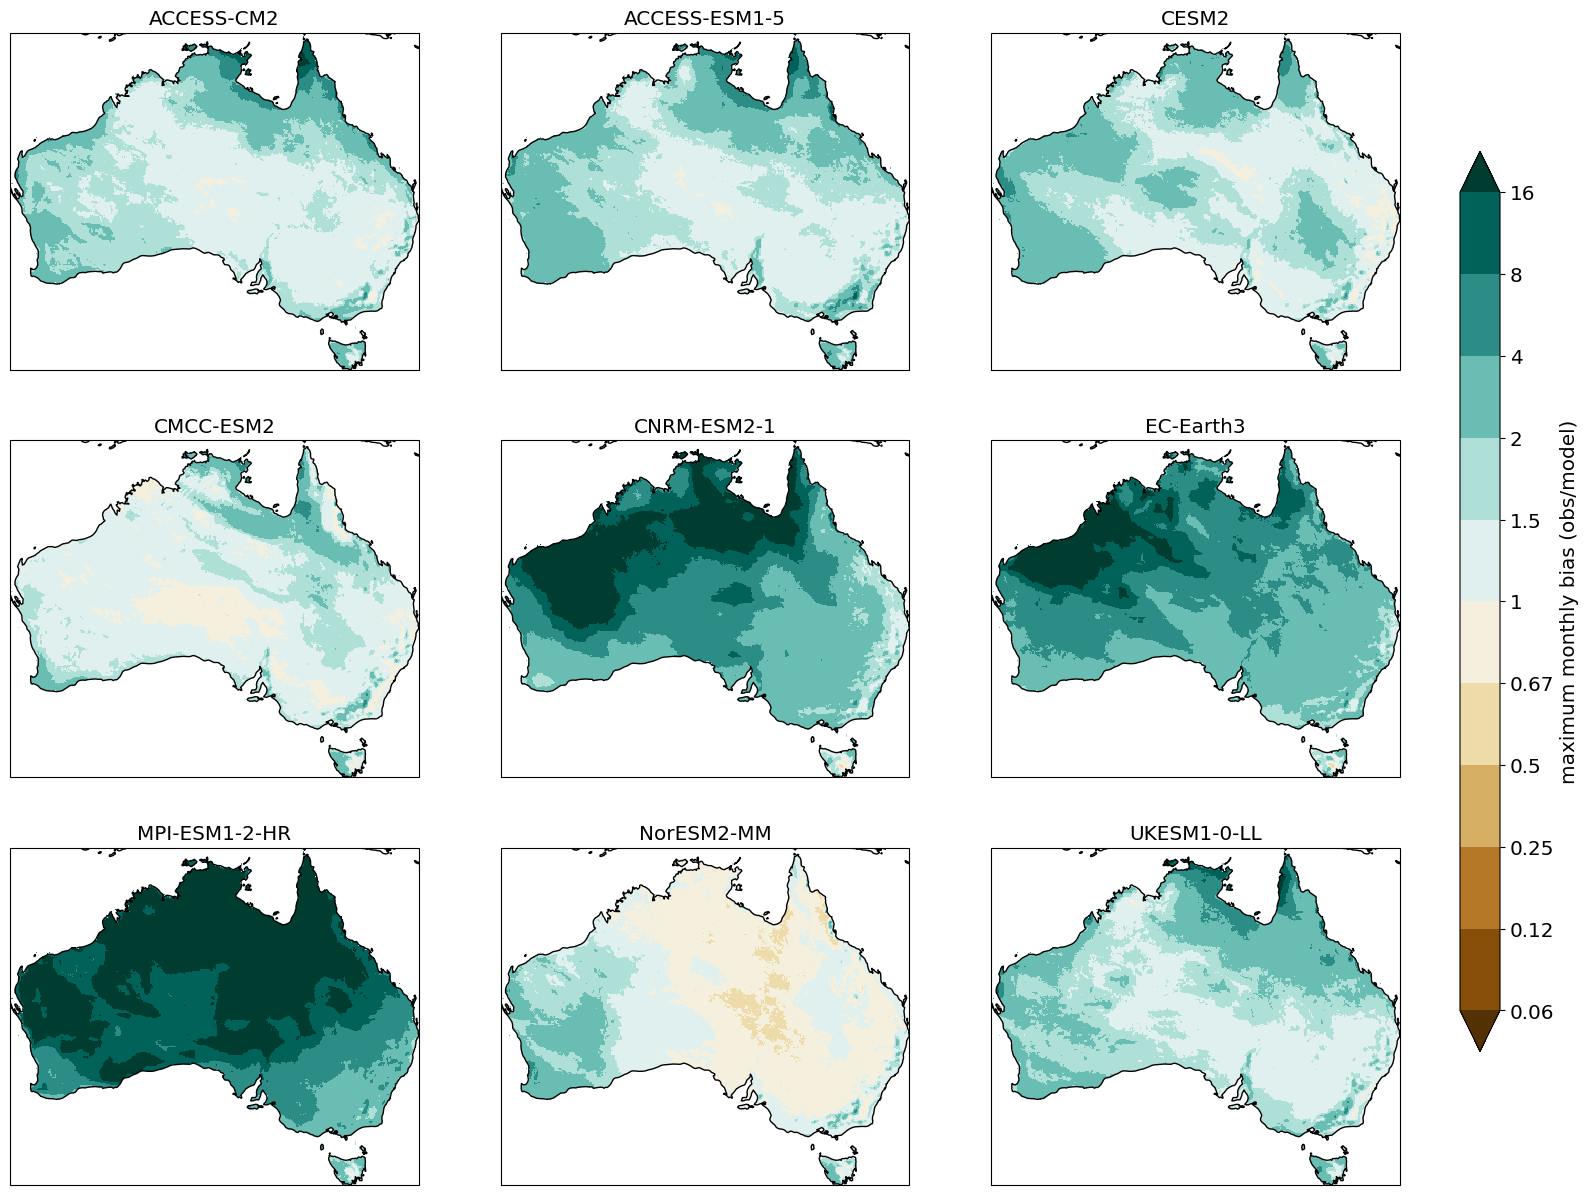

In [15]:
plot_max_bias(model_bias_barra_max_dict, 'BARRA-R2')

In [16]:
model_bias_agcd_max_dict = calc_max_bias(da_agcd_clim)

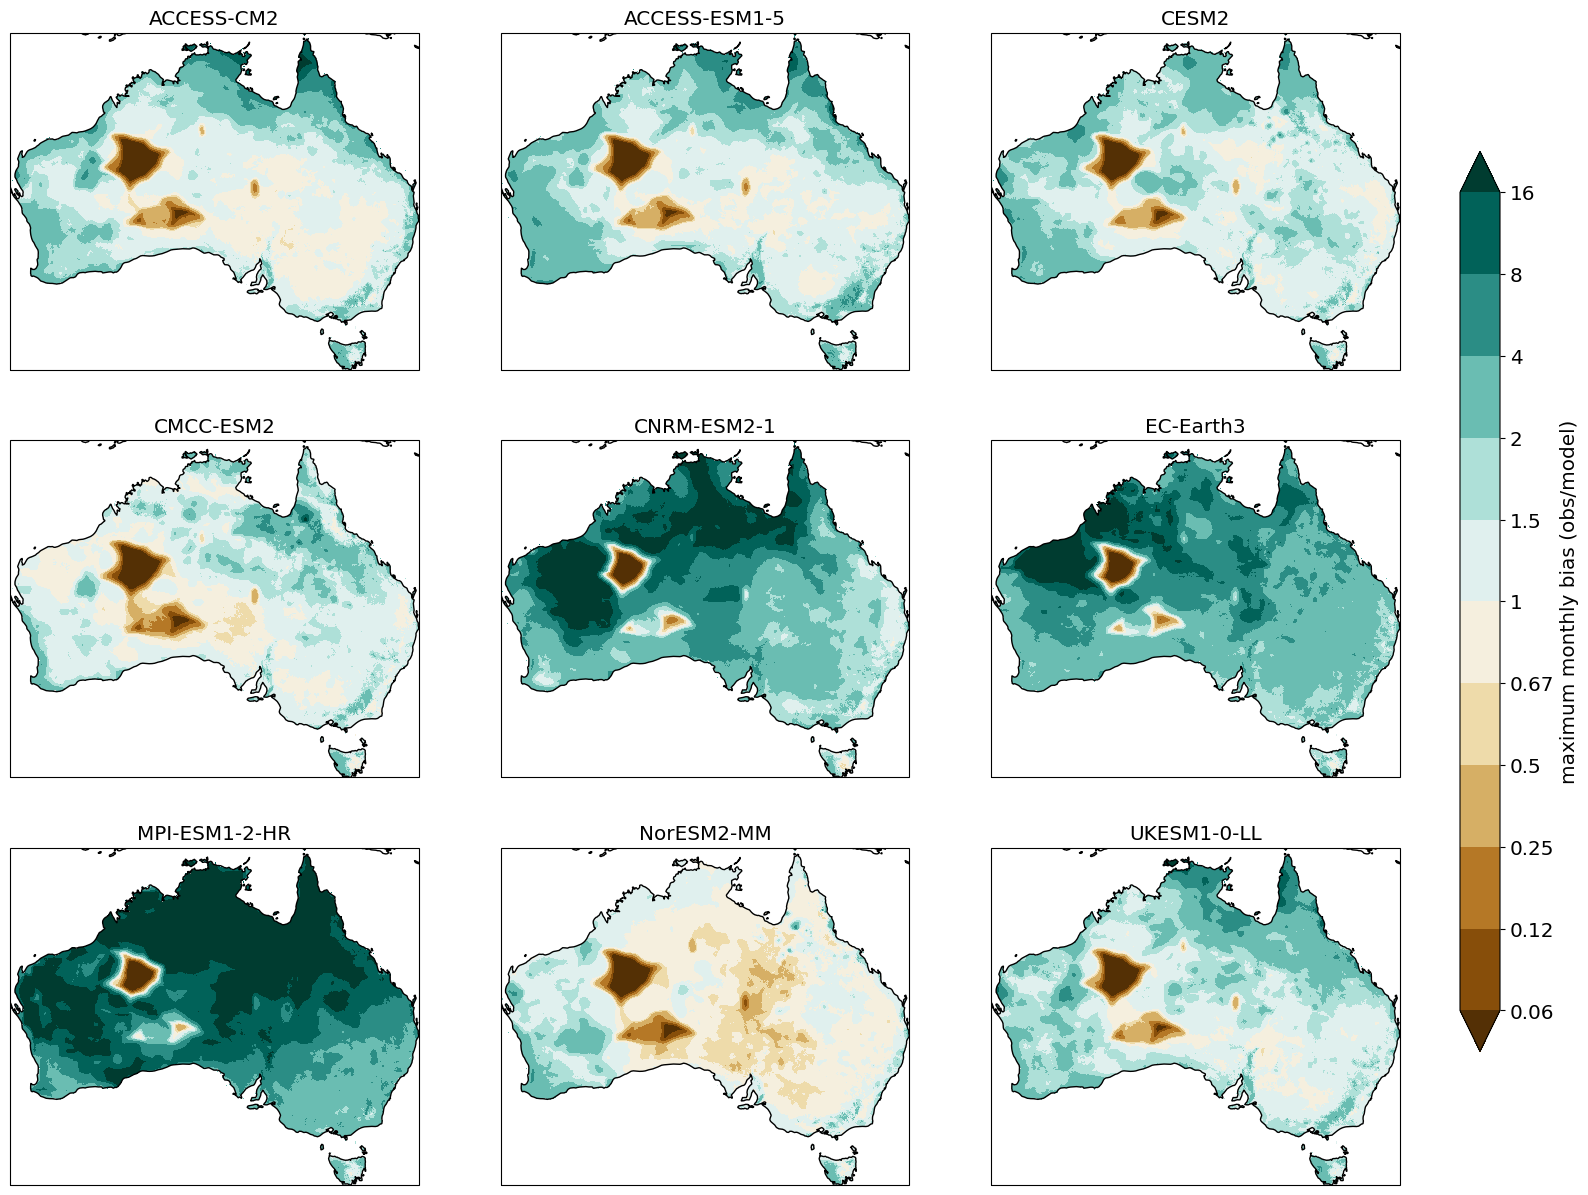

In [17]:
plot_max_bias(model_bias_agcd_max_dict, 'AGCD')